In [1]:
import numpy as np
import pandas as pd
import datetime as dt
from pylab import mpl, plt
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
np.random.seed(1000)
%matplotlib inline

In [2]:
x = np.linspace(0, 10, 500)
y = 4 + 2 * x + np.random.standard_normal(len(x)) * 2

In [3]:
reg=np.polyfit(x,y,1)

Text(0, 0.5, 'y')

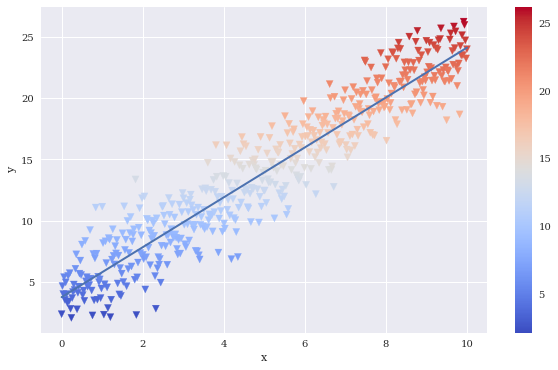

In [4]:
plt.figure(figsize=(10, 6))
plt.scatter(x, y, c=y, marker='v', cmap='coolwarm')
plt.plot(x, np.polyval(reg,x), lw=2.0)
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')

In [5]:
import pymc3 as pm

In [9]:
%%time
with pm.Model() as model:
    alpha=pm.Normal('alpha',mu=0,sd=20)
    beta=pm.Normal('beta',mu=0,sd=10)
    sigma=pm.Uniform('sigma',lower=0,upper=10)
    y_est=alpha+beta*x
    likelihood = pm.Normal('y', mu=y_est, sd=sigma,
observed=y)
    start=pm.find_MAP()
    step=pm.NUTS()
    trace=pm.sample(100,tune=1000,start=start,progressbar=True,
                   verbose=False)
    

KeyboardInterrupt: 

In [6]:
%%time
with pm.Model() as model:
    # model
    alpha = pm.Normal('alpha', mu=0, sd=20)
    beta = pm.Normal('beta', mu=0, sd=10)
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    y_est = alpha + beta * x
    likelihood = pm.Normal('y', mu=y_est, sd=sigma,
    observed=y)
    # inference
    start = pm.find_MAP()
    step = pm.NUTS()
    trace = pm.sample(100, tune=1000, start=start,
    progressbar=True, verbose=False)

WARNING (theano.gof.compilelock): Overriding existing lock by dead process '11928' (I am process '14636')
logp = -1,067.8, ||grad|| = 60.354: 100%|█████████████████████████████████████████████| 28/28 [00:00<00:00, 879.62it/s]
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta, alpha]
Sampling 2 chains: 100%|███████████████████████████████████████████████████████| 2200/2200 [00:09<00:00, 234.23draws/s]


Wall time: 1min 53s


In [7]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,3.775298,0.166717,0.012310,3.445725,4.046558,129.420943,1.009928
beta,2.032610,0.029799,0.002221,1.974223,2.088547,127.910501,1.010376
sigma,2.016417,0.058824,0.004193,1.910850,2.123398,181.437443,0.995043


In [9]:
trace[0]

{'alpha': 3.670554432751944,
 'beta': 2.0790783689432937,
 'sigma_interval__': -1.427667709875937,
 'sigma': 1.9346234218331693}

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000185B32B3F98>,
      dtype=object)

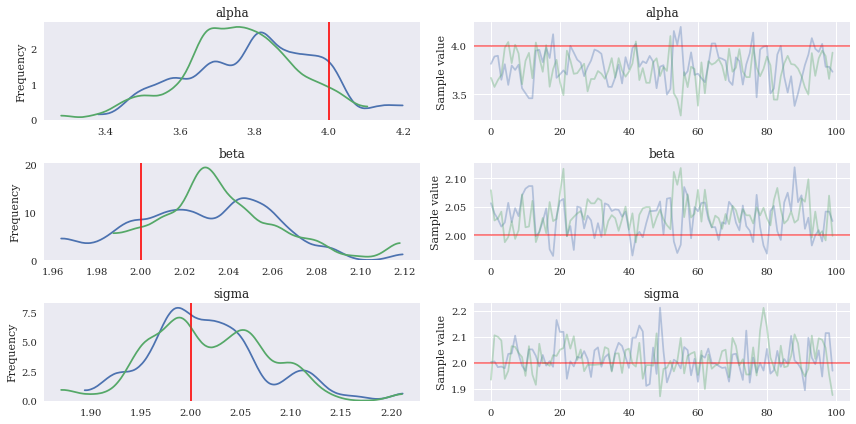

In [10]:
pm.traceplot(trace, lines={'alpha': 4, 'beta': 2, 'sigma': 2})

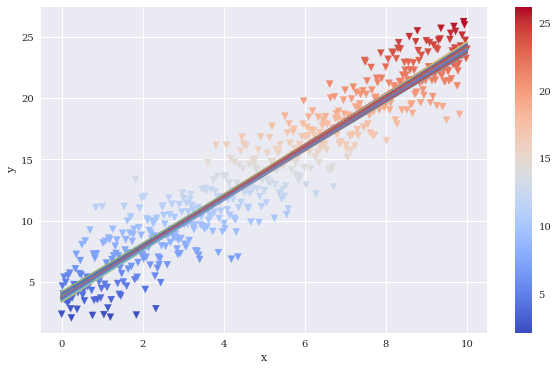

In [11]:
plt.figure(figsize=(10,6))
plt.scatter(x,y,c=y,marker='v',cmap='coolwarm')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
for i in range(len(trace)):
    plt.plot(x,trace['alpha'][i]+trace['beta'][i]*x)

In [12]:
len(trace)

100

In [13]:
raw = pd.read_csv('tr_eikon_eod_data.csv',
index_col=0, parse_dates=True)

In [14]:
data = raw[['GDX', 'GLD']].dropna()

In [15]:
data = data / data.iloc[0]

In [16]:
data.ix[-1] / data.ix[0] - 1

C:\An\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


GDX   -0.532383
GLD    0.080601
dtype: float64

In [21]:
data.corr()

,GDX,GLD
GDX,1.00000,0.71539
GLD,0.71539,1.00000


In [22]:
data.index[:3]

DatetimeIndex(['2010-01-04', '2010-01-05', '2010-01-06'], dtype='datetime64[ns]', name='Date', freq=None)

In [17]:
mpl_dates = mpl.dates.date2num(data.index.to_pydatetime())

In [25]:
mpl_dates[:10]

array([733776., 733777., 733778., 733779., 733780., 733783., 733784.,
       733785., 733786., 733787.])

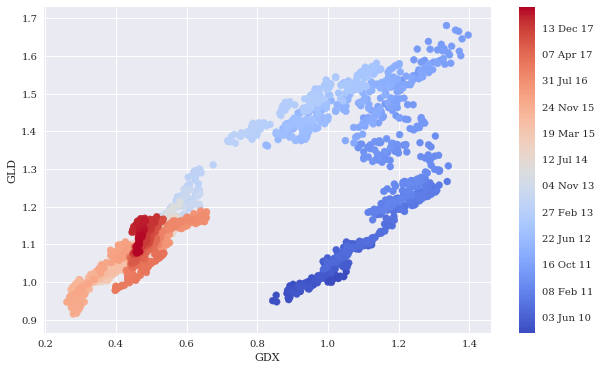

In [18]:
plt.figure(figsize=(10, 6))
plt.scatter(data['GDX'], data['GLD'], c=mpl_dates,
marker='o', cmap='coolwarm')
plt.xlabel('GDX')
plt.ylabel('GLD')
plt.colorbar(ticks=mpl.dates.DayLocator(interval=250),
format=mpl.dates.DateFormatter('%d %b %y'))


In [19]:
from pymc3.distributions.timeseries import GaussianRandomWalk
subsample_alpha = 50
subsample_beta = 50

In [20]:
model_randomwalk = pm.Model()
with model_randomwalk:
    sigma_alpha = pm.Exponential('sig_alpha', 1. / .02, testval=.1)
    sigma_beta = pm.Exponential('sig_beta', 1. / .02, testval=.1)
    alpha = GaussianRandomWalk('alpha', sigma_alpha ** -2,
    shape=int(len(data) / subsample_alpha))
    beta = GaussianRandomWalk('beta', sigma_beta ** -2,
    shape=int(len(data) / subsample_beta))
    alpha_r = np.repeat(alpha, subsample_alpha)
    beta_r = np.repeat(beta, subsample_beta)
    regression = alpha_r + beta_r * data['GDX'].values[:2100]
    sd = pm.Uniform('sd', 0, 20)
    likelihood = pm.Normal('GLD', mu=regression, sd=sd,
    observed=data['GLD'].values[:2100])

In [1]:
import theano

In [2]:
theano.__version__

'1.0.4'

In [ ]:
%%time
import scipy.optimize as sco
with model_randomwalk:
    start = pm.find_MAP(vars=[alpha, beta],
    fmin=sco.fmin_l_bfgs_b)
    step = pm.NUTS(scaling=start)
    trace_rw = pm.sample(250, tune=1000, start=start,
progressbar=True)

C:\An\lib\site-packages\pymc3\tuning\starting.py:92: UserWarning: In future versions, set the optimization algorithm with a string. For example, use `method="L-BFGS-B"` instead of `fmin=sp.optimize.fmin_l_bfgs_b"`.
  warnings.warn('In future versions, set the optimization algorithm with a string. '
logp = -6,657:   2%|█                                                               | 82/5000 [00:00<00:21, 226.27it/s]
